# Using custom labelling schemes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_custom_labels_tutorial.ipynb)

##### What we'll cover:
    
* Labelling schemes supported by DeepOF.
* How to create a new labelling scheme and integrate it with the unsupervised pipeline.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# # Note: because of how colab handles the installation of local packages, this cell will kill your runtime.
# # This is not an error! Just continue with the cells below.
# import os
# !git clone -q https://github.com/mlfpm/deepof.git
# !pip install -q -e deepof --progress-bar off
# os.chdir("deepof")
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/4J9fApqfNaoBsq6/download
# !unzip tutorial_files.zip

In [3]:
# import os
# os.chdir("deepof")
# import os, warnings
# warnings.filterwarnings('ignore')

Let's start by importing some packages. We'll use python's os library to handle paths, pickle to load saved objects, pandas to load data frames, and the data entry API within DeepOF, located in deepof.data

In [4]:
import os
import pandas as pd
import pickle
import deepof.data

We'll also need some plotting gear:

In [5]:
from IPython import display
from networkx import Graph, draw
import deepof.visuals
import matplotlib.pyplot as plt
import seaborn as sns

### Recap: labelling schemes supported by DeepOF

DeepOF supports two labelling schemes out of the box: the `deepof_14` scheme, selected by default, and `deepof_8`, a reduced set of tracking labels that is common among, for example, [SimBA](https://goldenneurolab.com/simba) users.

**NOTE**: This is not necessary if you use the matrix representations introduced in the previous tutorial. If you'd like to try out the graph representations we explored, however, but you have a different labelling scheme, this is the place to be.

<img src="./Assets/deepof_DLC_tagging.png"  width="800">

While, as mentioned above, `deepof_14` is selected by default, the provided alternative can be selected when defining a new `deepof.Project` instance:

In [6]:
my_deepof_project = deepof.data.Project(
    project_path=os.path.join("tutorial_files"),
    video_path=os.path.join("tutorial_files/Videos/"),
    table_path=os.path.join("tutorial_files/Tables/"),
    project_name="deepof_tutorial_project",
    arena="circular-autodetect",
    animal_ids=["B", "W"],
    video_format=".mp4",
    bodypart_graph="deepof_8",  # Can also be set to 'deepof_14' (default), 'deepof_11' or take a custom graph
    video_scale=380,
    iterative_imputation="partial",
    smooth_alpha=1,
    exp_conditions=None,
)

In [7]:
my_deepof_project = my_deepof_project.create(force=True)

Setting up project directories...


Computing areas               : 100%|██████████| 6/6 [00:01<00:00,  4.93table/s]
It seems you're using deepof_8 or a custom labelling scheme which is missing key body parts.
You can proceed, but not all areas will be computed.



Done!


We can take a look at the constructed graph in this case (you can see how the default looks like in the previous tutorial, or change the labelling scheme to `deepof_14` in the cell above if you're following in colab):

In [8]:
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Center",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)

Reshaping                     : 100%|██████████| 2/2 [00:00<00:00, 10.70table/s]


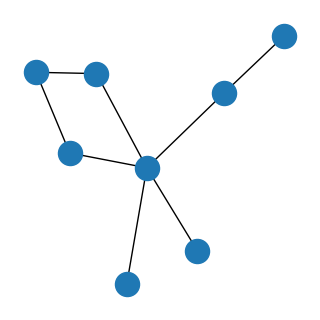

In [9]:
plt.figure(figsize=(3, 3))
draw(Graph(adj_matrix))
plt.show()

We indeed see a graph with 8 labels! The diamond shape corresponds to nose, ears and center. The outer branches to both sides and the tail.

This will adapt the whole downstream pipeline to work with the 8-label scheme. A more flexible alternative, if neither scheme fits your data, is to create a custom graph. Next, let's see how this can be achieved!

### Creating a new labelling scheme

Now, on for a slightly more involved task. What happens if we want another labelling scheme, not supported by DeepOF? We need to build the graph by hand using an adjacency list, and pass it to the `deepof.Project` constructor. Let's see! We'll adapt the `deepof_8` labelling scheme to include the full tail, which should look like this:

<img src="./Assets/deepof_custom_tagging.png"  width="400">

To start, we should create a Python dictionary specifying all connections we want. To be clear, keys in the dictionary will be connected to every element in the lists passed as values. There is no unique way of implementing this, so feel free to be creative! But an example that works is the following:

In [10]:
deepof_custom = {
    "Nose": ["Left_ear", "Right_ear"],
    "Center": ["Left_ear", "Right_ear", "Left_fhip", "Right_fhip", "Tail_base"],
    "Tail_base": ["Tail_1"],
    "Tail_1": ["Tail_2"],
    "Tail_2": ["Tail_tip"],
}

Here, `Nose` is connected to `Left_ear` and `Right_ear`, and so on. Next, we'll pass this structure to the `bodypart_graph` parameter in the `deepof.Project` constructor.

In [11]:
my_deepof_project = deepof.data.Project(
    project_path=os.path.join("tutorial_files"),
    video_path=os.path.join("tutorial_files/Videos/"),
    table_path=os.path.join("tutorial_files/Tables/"),
    project_name="deepof_tutorial_project",
    arena="circular-autodetect",
    animal_ids=["B", "W"],
    video_format=".mp4",
    bodypart_graph=deepof_custom,  # Can also be set to 'deepof_14' (default), 'deepof_11' or 'deepof_8'
    video_scale=380,
    iterative_imputation="partial",
    smooth_alpha=1,
    exp_conditions=None,
)

In [12]:
my_deepof_project = my_deepof_project.create(force=True)

Setting up project directories...


Computing areas               : 100%|██████████| 6/6 [00:00<00:00,  9.83table/s]
It seems you're using deepof_8 or a custom labelling scheme which is missing key body parts.
You can proceed, but not all areas will be computed.



Done!


### Getting a custom graph dataset for the unsupervised pipeline

Now everything works the same way as before! Let's then obtain a new graph dataset using this custom labelling scheme, and make sure the obtained graph matches our expectations:

In [13]:
graph_preprocessed_coords, shapes, adj_matrix, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
    animal_id="B", # Comment out for multi-animal embeddings
    center="Center",
    align="Tail_base",
    window_size=25,
    window_step=1,
    test_videos=1,
    preprocess=True,
    scale="standard",
)

Reshaping                     : 100%|██████████| 2/2 [00:00<00:00,  8.66table/s]


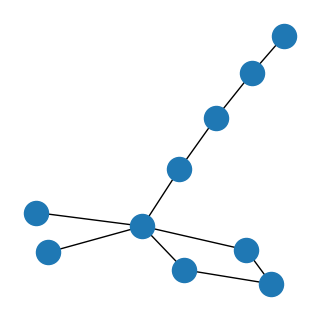

In [14]:
plt.figure(figsize=(3, 3))
draw(Graph(adj_matrix))
plt.show()

And that's it! Now you should be able to adapt the unsupervised pipeline within DeepOF to any labelling scheme of choice. Note that this should still work with bottom-up or side view videos.

### Wrapping up

Thank you for making it until the end. This was a slightly more involved tutorial for those users that do not rely on top-down labels like those provided out of the box. Stay tuned for more content, and make sure to raise an [issue](https://github.com/mlfpm/deepof/issues) in our GitHub repository if you have any questions!